In [1]:
import pandas as pd
import glob
from scipy import stats

In [2]:
import sys
import os
current_path = os.getcwd()
sys.path.append(f"{current_path}/..")

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"

# Sentence

In [ ]:

scores_all = []
for lp in ["de_en", "fr_en", "pt-br_en", "en_de", "en_fr", "en_pt-br"]:
    df = pd.read_csv("../data/all_data.csv", index_col=0)
    df = df[df.lp == lp]
    metric_names = []
    for scores_path in glob.glob(f"../scores/sentence/{lp}/*"):
        metric_name = scores_path.split("/")[-1].split(".")[0]
        metric_names.append(metric_name)
        df[metric_name] = pd.read_csv(scores_path).values
        scores_all.append([lp, metric_name,  'ALL', f"{stats.spearmanr(df[metric_name] , df['google_mqm']).statistic:.3f}"])
        scores_all.append([lp, metric_name, 'Imperfect', f"{stats.spearmanr(df[df.mqm!=100][metric_name] , df[df.mqm!=100]['google_mqm']).statistic:.3f}"])
    
scores_df = pd.DataFrame(scores_all)
scores_df.columns = ["lp", "metric_name", 'type', "score"]


In [ ]:
scores_df[scores_df.type=='ALL'][["lp", "metric_name", "score"]].pivot(index='metric_name', columns='lp')['score']

In [ ]:
scores_df[scores_df.type=='Imperfect'][["lp", "metric_name", "score"]].pivot(index='metric_name', columns='lp')['score']

# Context

In [4]:
dfs_all = pd.read_csv("../data/all_data.csv", index_col=0)
orig_columns = dfs_all.columns.to_list()
for scores_path in glob.glob("../scores/context/*"):
    metric_name = scores_path.split("/")[-1].split(".")[0]
    scores_df = pd.read_csv(scores_path, index_col=0)
    dfs_all = pd.merge(dfs_all, scores_df, on=orig_columns, how='left')
    dfs_all.drop(columns=['source_with_context', 'mt_with_context', 'ref_with_context'], inplace=True)
    dfs_all.rename(columns={'metric': metric_name}, inplace=True)
dfs_all["Source Issue"] = dfs_all["typology_error"].fillna('').str.contains("Source Issue")
dfs_all["source length"] = dfs_all["source"].apply(lambda x: len(x))


In [39]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [7]:
from scipy import stats
import numpy as np
import pandas as pd
from collections import Counter

def get_corr_map(dfs_all):
    all_corr = []

    metric_name_map ={
        "DocCOMET": "Comet-22", 
        "DocCOMET-QE": "Comet-20-QE (mt)", 
        "DocCOMET-QE-reference": "Comet-20-QE (reference)", 
    }

    for metric_name in ["DocCOMET", "DocCOMET-QE", "DocCOMET-QE-reference"]:
        for ws in range(0, 10):
            all_xxen_corr_within = []
            all_enxx_corr_within = []
            all_enxx_corr_across = []
            all_xxen_corr_across = []
            for lp_name, df_group in dfs_all.groupby("lp"):

                lp_scores = df_group[f"{metric_name}-within-{ws}"].to_list()
                mqm_scores = df_group["google_mqm"].to_list()

                if lp_name.endswith("en"):
                    all_xxen_corr_within.append(stats.spearmanr(mqm_scores, lp_scores).statistic)
                else:
                    all_enxx_corr_within.append(stats.spearmanr(mqm_scores, lp_scores).statistic)

                lp_scores = df_group[f"{metric_name}-across-{ws}"].to_list()
                mqm_scores = df_group["google_mqm"].to_list()
                
                if lp_name.endswith("en"):
                    all_xxen_corr_across.append(stats.spearmanr(mqm_scores, lp_scores).statistic)
                else:
                    all_enxx_corr_across.append(stats.spearmanr(mqm_scores, lp_scores).statistic)
            
            all_corr.append([f"{metric_name_map[metric_name]}", "across", ws, "Average (Agent)", np.mean(all_enxx_corr_across)])
            all_corr.append([f"{metric_name_map[metric_name]}", "across", ws, "Average (Customer)", np.mean(all_xxen_corr_across)])
            all_corr.append([f"{metric_name_map[metric_name]}", "within", ws, "Average (Agent)", np.mean(all_enxx_corr_within)])
            all_corr.append([f"{metric_name_map[metric_name]}", "within", ws, "Average (Customer)", np.mean(all_xxen_corr_within)])

    return all_corr

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

new_df = get_corr_map(dfs_all)
scores_df = pd.DataFrame(new_df)
scores_df.columns =["Metric", "Context Type", "Context Window Size", "lp_name", "Correlation"]

# Setting the figure size and resolution (DPI)
plt.figure(figsize=(12, 10))

sns.set_context("notebook", font_scale=3)

with sns.axes_style("darkgrid"):
    ax = sns.lineplot(data=scores_df[scores_df["lp_name"] == 'Average (Customer)'], linewidth=3, x='Context Window Size', y="Correlation", hue='Metric', style="Context Type")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(f'customer_context_all.pdf', dpi=100, bbox_inches='tight')


plt.figure(figsize=(12, 10))
with sns.axes_style("darkgrid"):
    ax = sns.lineplot(data=scores_df[scores_df["lp_name"] == 'Average (Agent)'], linewidth=3, x='Context Window Size', y="Correlation", hue='Metric', style="Context Type")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(f'agent_context_all.pdf', dpi=100, bbox_inches='tight')


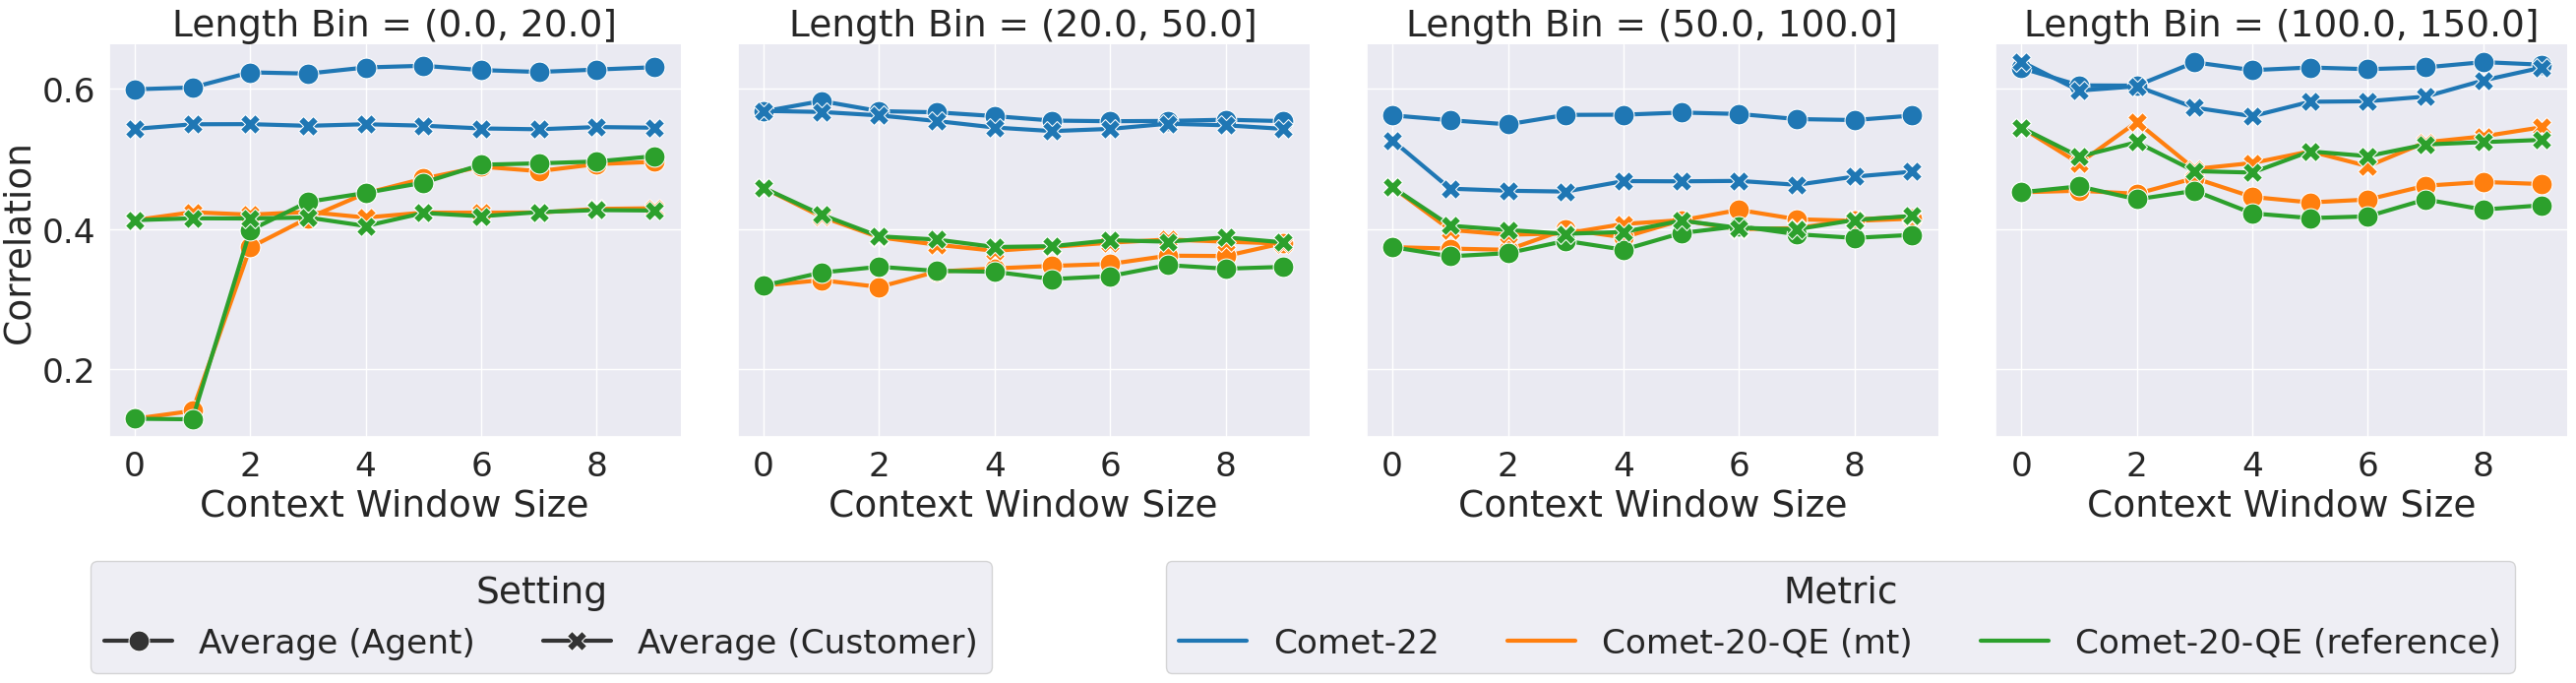

In [43]:
dfs_all['source length binned'] = pd.cut(dfs_all['source length'], [0, 20, 50, 100, 150])

combined_df = pd.DataFrame()

for bin in dfs_all['source length binned'].sort_values().unique():
    num_bin = len( dfs_all[dfs_all["source length binned"]==bin] )
    if num_bin==0: continue
    new_df = get_corr_map( dfs_all[dfs_all["source length binned"]==bin])

    scores_df = pd.DataFrame(new_df)
    scores_df.columns =["Metric", "Context Type", "Context Window Size", "Setting", "Correlation"]
    scores_df["Length Bin"] = bin
    combined_df = pd.concat([combined_df, scores_df], ignore_index=True)


sns.set_context("notebook", font_scale=2.25)
with sns.axes_style("darkgrid"):
  g = sns.FacetGrid(combined_df[combined_df["Context Type"] == "across"], col="Length Bin")
  g.map_dataframe(sns.lineplot, linewidth=3,
      x='Context Window Size',
      y="Correlation",
      hue='Metric',
      style='Setting',
      markers=True,
      dashes=False, markersize=15)
  g.fig.set_size_inches(30, 12)
  plt.subplots_adjust(wspace=0.1)

  # Get handles and labels for hue and style separately
  hue_handles, hue_labels = g.axes[0, 0].get_legend_handles_labels()
  style_handles, style_labels = g.axes[0, 0].get_legend_handles_labels()

  # Filter handles and labels
  hue_handles = hue_handles[1:len(combined_df['Metric'].unique())+1]
  hue_labels = hue_labels[1:len(combined_df['Metric'].unique())+1]

  style_handles = style_handles[len(combined_df['Metric'].unique())+2:]
  style_labels = style_labels[len(combined_df['Metric'].unique())+2:]

  # Create separate legends
  g.fig.legend(handles=hue_handles, labels=hue_labels, title='Metric', loc='lower center', ncol=len(hue_labels), frameon=True, bbox_to_anchor=(0.72, 0.2))
  g.fig.legend(handles=style_handles, labels=style_labels, title='Setting', loc='lower center', ncol=len(style_labels), frameon=True, bbox_to_anchor=(0.28, 0.2))

  # plt.title("Correlation Across Context Window Sizes for Different Length Bins")
  plt.savefig(f'all_context_google.pdf', dpi=150, bbox_inches='tight')
  

In [44]:
error_types = set()
for group_name, df in dfs_all.groupby(["lp", "model"]):
  error_counter = {}
  for i, row in df.iterrows():
    if isinstance(row["typology_error"], str):
      errors = row["typology_error"].split("/")
      for error in errors:
        error_types.add(error)
        if error not in error_counter:
          error_counter[error] = 1
        else:
          error_counter[error] += 1


In [45]:
sub_df = dfs_all
for error in error_types:
    sub_df[error] = sub_df["typology_error"].apply(lambda x: True if isinstance(x, str) and (error in x.split("/")) else False)

In [46]:
scores = []
for error in error_types:
    for metric in ['DocCOMET-QE-across-0', 'DocCOMET-QE-across-2']:
        lp_scores = sub_df[sub_df[error]==True][metric].to_list()
        mqm_scores = sub_df[sub_df[error]==True]["mqm"].to_list()
        if metric == "DocCOMET-QE-across-0":
            metric_name = "no"
        else:
            metric_name = "yes"
        scores.append([error, len(sub_df[sub_df[error]==True]), metric_name, stats.spearmanr(mqm_scores, lp_scores).statistic])


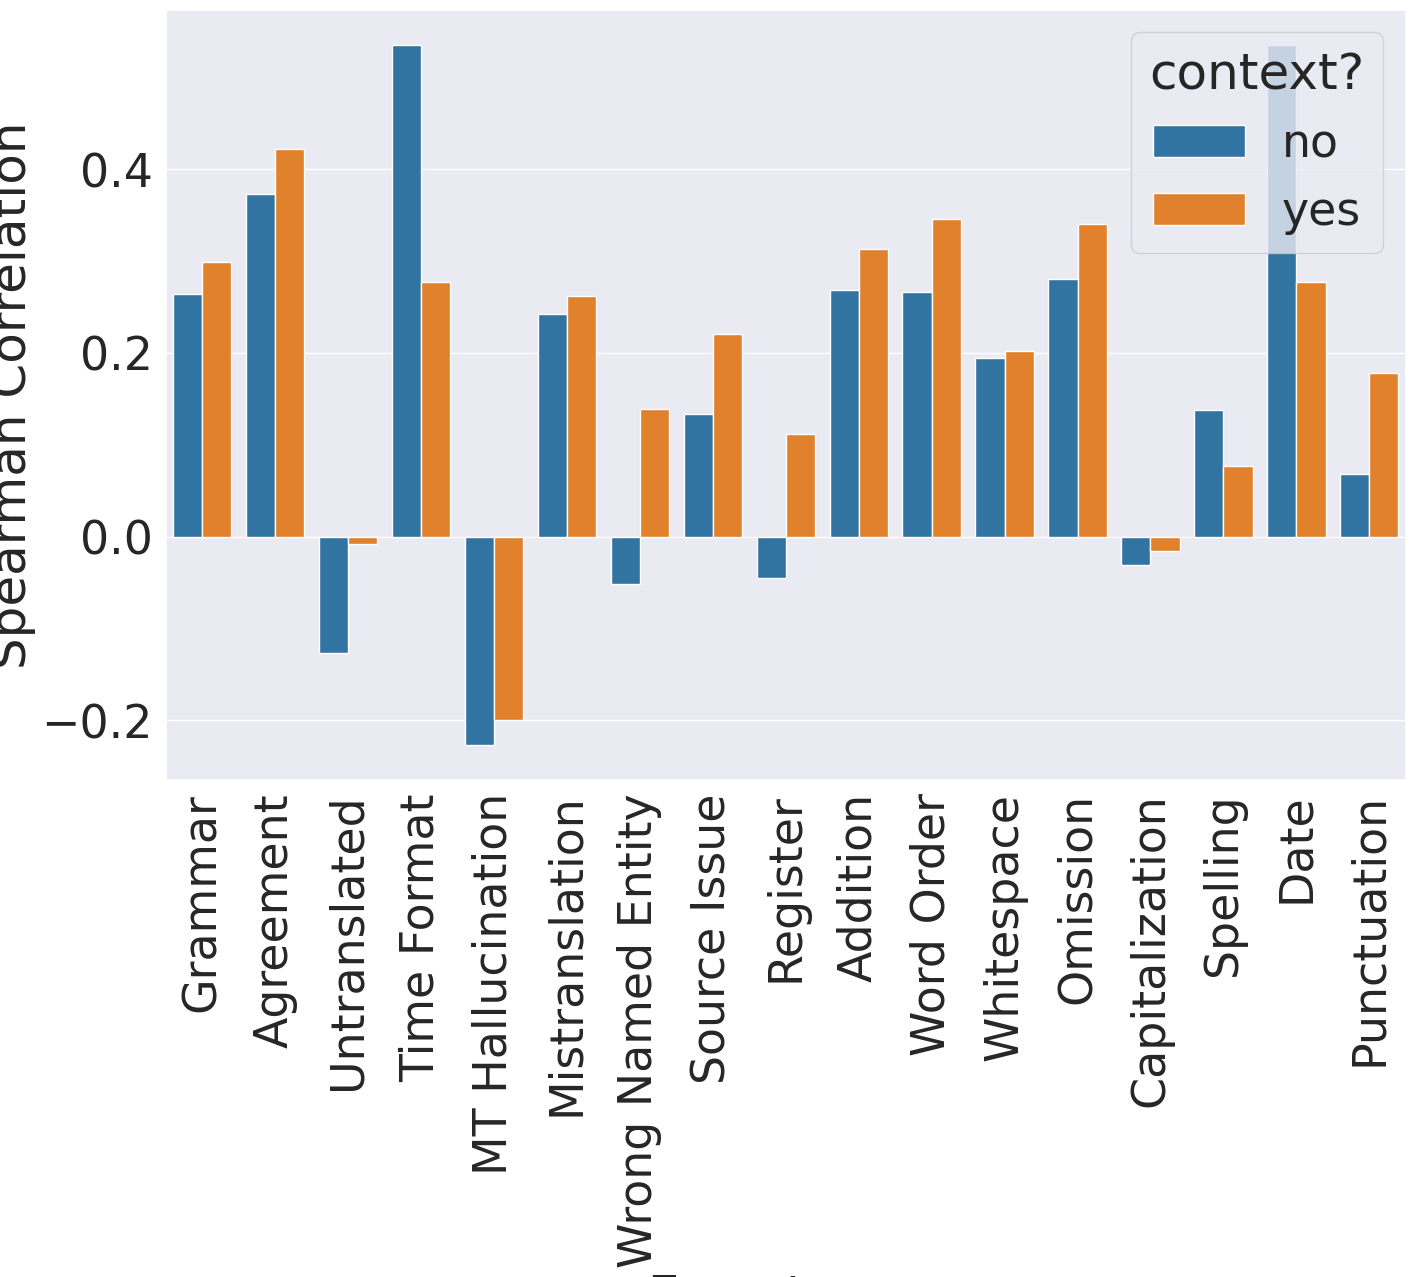

In [47]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

scores_df = pd.DataFrame(scores)
scores_df.columns = ["Error types", "len", "context", "Spearman Correlation"]

plt.figure(figsize=(16, 10))

sns.set_context("notebook", font_scale=3)

with sns.axes_style("darkgrid"):
  sns.barplot(scores_df[scores_df.len>=20], x="Error types", y="Spearman Correlation", hue="context")
  plt.xticks(rotation=90)
  legend = plt.legend(loc='upper right')
  legend.set_title("context?")
  plt.savefig(f'error_types.pdf', dpi=150, bbox_inches='tight')

In [48]:
sub_df = df
error_types = ["neutral","major", "minor", "critical"]
for error in ["neutral","major", "minor", "critical"]:
    sub_df[error] = sub_df["severity"].apply(lambda x: True if isinstance(x, str) and (error in x.split("/")) else False)

In [49]:
from scipy import stats
import numpy as np
scores = []
for error in error_types:
    for metric in ['DocCOMET-QE-across-0', 'DocCOMET-QE-across-2']:
        lp_scores = sub_df[sub_df[error]==True][metric].to_list()
        mqm_scores = sub_df[sub_df[error]==True]["mqm"].to_list()
        if metric == "DocCOMET-QE-across-0":
            metric_name = "no"
        else:
            metric_name = "yes"
        scores.append([error, len(sub_df[sub_df[error]==True]), metric_name, stats.spearmanr(mqm_scores, lp_scores).statistic])


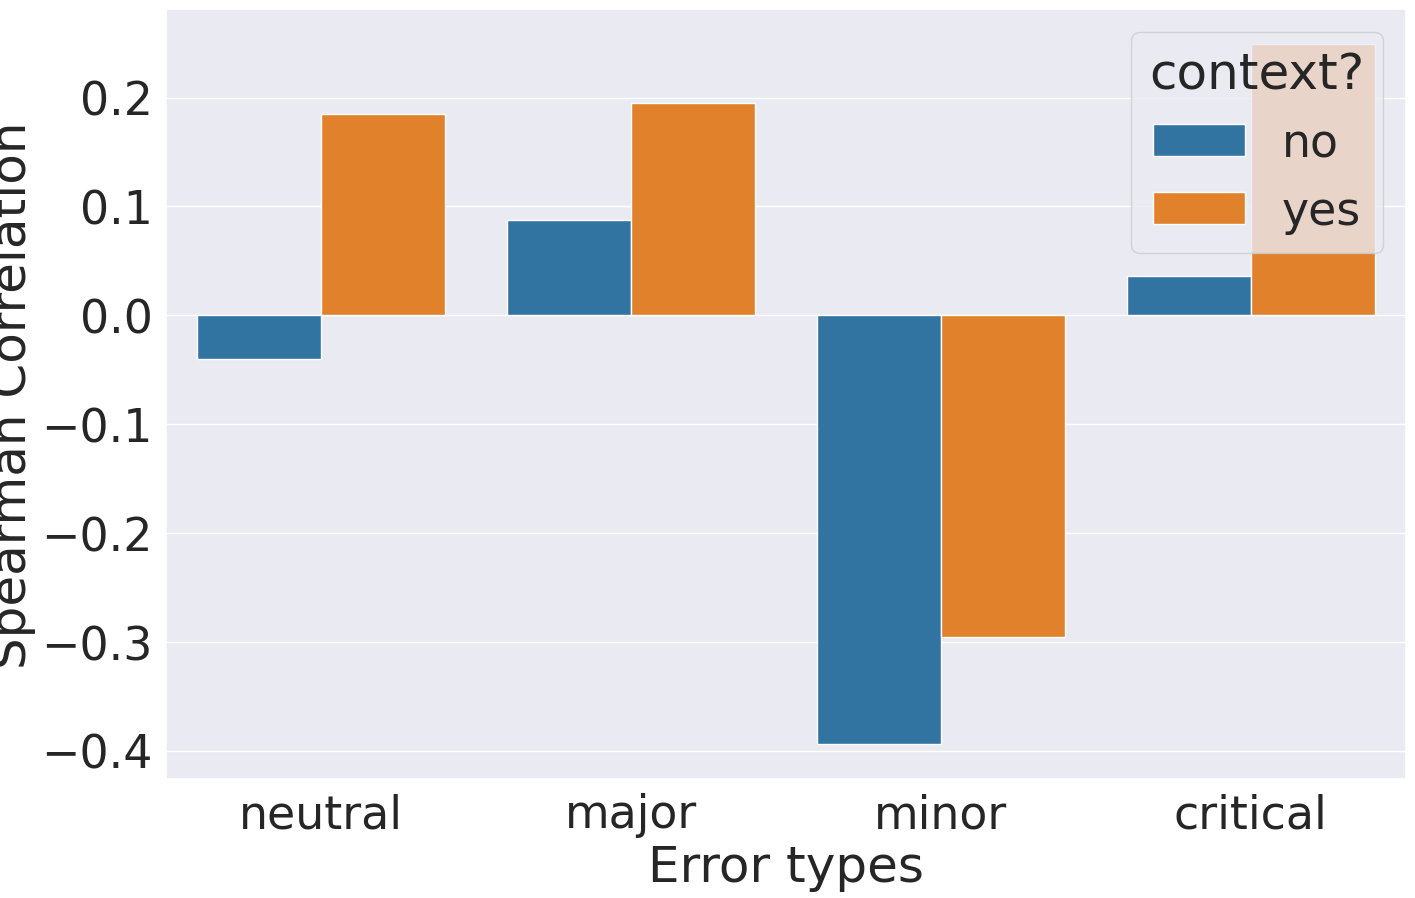

In [50]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

scores_df = pd.DataFrame(scores)
scores_df.columns = ["Error types", "len", "context", "Spearman Correlation"]

plt.figure(figsize=(16, 10))

sns.set_context("notebook", font_scale=3)

with sns.axes_style("darkgrid"):
  sns.barplot(scores_df[scores_df.len>=20], x="Error types", y="Spearman Correlation", hue="context")
  # plt.xticks(rotation=90)
  legend = plt.legend(loc='upper right')
  legend.set_title("context?")
  plt.savefig(f'error_severity.pdf', dpi=150, bbox_inches='tight')

# Context-LLM

In [51]:
import pandas as pd
from run_context_llm import parse_mqm_answer

context_llm = pd.read_csv("../scores/gpt_ende_1k.csv")

context_llm[["GPT-4-context-1shot-score", "GPT-4-context-1shot-critical-count", "GPT-4-context-1shot-major-count", "GPT-4-context-1shot-minor-count"]] = context_llm["GPT-4-context-annotations-1shot"].apply(parse_mqm_answer)
context_llm[["GPT-4-1shot-score", "GPT-4-1shot-critical-count", "GPT-4-1shot-major-count", "GPT-4-1shot-minor-count"]] = context_llm["GPT-4-annotations-1shot"].apply(parse_mqm_answer)


critical: none
No error level for critical: none
major: none
No error level for major: none
critical: none
No error level for critical: none
major: none
No error level for major: none
no minor errors.


In [52]:
from collections import Counter
def get_score(errors):
    if not isinstance(errors, str):
        return 0
    else:
        error_count = Counter(errors.split("/"))
        score = - (error_count["minor"]*1 + error_count["major"]*5 + error_count["critical"]*10  )
        return score

context_llm["google_mqm"] = context_llm["severity"].apply(get_score)

In [53]:
context_llm[["google_mqm", "major", "minor", "critical", "GPT-4-1shot-score", "GPT-4-context-1shot-score","CometQE", "CometMT"]].corr(method="spearman")

,google_mqm,major,minor,critical,GPT-4-1shot-score,GPT-4-context-1shot-score,CometQE,CometMT
google_mqm,1.000000,-0.578422,-0.624297,-0.582293,0.642042,0.655027,0.392647,0.564295
major,-0.578422,1.000000,0.084509,0.181874,-0.441080,-0.519038,-0.283867,-0.363644
minor,-0.624297,0.084509,1.000000,0.076770,-0.319903,-0.286659,-0.291161,-0.330873
critical,-0.582293,0.181874,0.076770,1.000000,-0.457330,-0.454311,-0.203919,-0.348313
GPT-4-1shot-score,0.642042,-0.441080,-0.319903,-0.457330,1.000000,0.876343,0.444087,0.539123
GPT-4-context-1shot-score,0.655027,-0.519038,-0.286659,-0.454311,0.876343,1.000000,0.385730,0.510428
CometQE,0.392647,-0.283867,-0.291161,-0.203919,0.444087,0.385730,1.000000,0.608769
CometMT,0.564295,-0.363644,-0.330873,-0.348313,0.539123,0.510428,0.608769,1.000000


In [54]:
context_llm[context_llm.google_mqm!=0.0][["google_mqm", "major", "minor", "critical", "GPT-4-1shot-score", "GPT-4-context-1shot-score","CometQE", "CometMT"]].corr(method="spearman")

,google_mqm,major,minor,critical,GPT-4-1shot-score,GPT-4-context-1shot-score,CometQE,CometMT
google_mqm,1.000000,-0.495070,0.433240,-0.773718,0.512722,0.559599,0.261985,0.453602
major,-0.495070,1.000000,-0.393500,-0.017476,-0.286940,-0.403484,-0.250380,-0.303962
minor,0.433240,-0.393500,1.000000,-0.365585,0.198257,0.233933,-0.039425,0.145054
critical,-0.773718,-0.017476,-0.365585,1.000000,-0.427400,-0.383095,-0.144920,-0.329874
GPT-4-1shot-score,0.512722,-0.286940,0.198257,-0.427400,1.000000,0.873560,0.457480,0.532022
GPT-4-context-1shot-score,0.559599,-0.403484,0.233933,-0.383095,0.873560,1.000000,0.409981,0.519479
CometQE,0.261985,-0.250380,-0.039425,-0.144920,0.457480,0.409981,1.000000,0.695341
CometMT,0.453602,-0.303962,0.145054,-0.329874,0.532022,0.519479,0.695341,1.000000


# Document-level

In [ ]:
import sacrebleu
import pandas as pd
import glob
from collections import Counter
from metrics import CometQE
cometkiwi = CometQE()
import numpy as np
from tqdm import tqdm


def get_score(errors):
    if not isinstance(errors, str):
        return 0 
    else:
        error_count = Counter(errors.split("/"))
        score = - (error_count["minor"]*1 + error_count["major"]*5 + error_count["critical"]*10  )
        return score

dfs_all = pd.read_csv("../data/all_data.csv", index_col=0)
orig_columns = dfs_all.columns.to_list()
for scores_path in glob.glob("../scores/context/*"):
    metric_name = scores_path.split("/")[-1].split(".")[0]
    scores_df = pd.read_csv(scores_path, index_col=0)
    dfs_all = pd.merge(dfs_all, scores_df, on=orig_columns, how='left')
    dfs_all.drop(columns=['source_with_context', 'mt_with_context', 'ref_with_context'], inplace=True)
    dfs_all.rename(columns={'metric': metric_name}, inplace=True)
dfs_all["Source Issue"] = dfs_all["typology_error"].fillna('').str.contains("Source Issue")
dfs_all["source length"] = dfs_all["source"].apply(lambda x: len(x))

scores = []
for group_name, df_group in dfs_all.groupby(["doc_id", "model"]):
    references = df_group["reference"].tolist()
    hyps = df_group["mt"].tolist()
    srcs = df_group["source"].tolist()
    src_lang, tgt_lang = df_group["lp"].values[0].split("_")
    hyp_tokens = sum([len(x.split(" ")) for x in hyps])
    errors_aggregate = get_score(("/").join([x for x in df_group["severity"].to_list() if str(x) != 'nan'])) 
    scores.append([src_lang if src_lang!="en" else tgt_lang, "bleu", sacrebleu.corpus_bleu(hyps, [references]).score,  df_group["google_mqm"].mean()])
    scores.append([src_lang if src_lang!="en" else tgt_lang, "Comet-20-QE", df_group["DocCOMET-QE-within-0"].mean(),  df_group["google_mqm"].mean()])
    scores.append([src_lang if src_lang!="en" else tgt_lang, "Comet-22", df_group["DocCOMET-within-0"].mean(),  df_group["google_mqm"].mean()])

    kiwi_scores = cometkiwi.get_score(srcs, hyps)
    scores.append([src_lang if src_lang!="en" else tgt_lang, "CometKiwi-22", np.mean(kiwi_scores),  df_group["google_mqm"].mean()])


In [ ]:
ws = 6
stride = 6
for group_name, df_group in tqdm(dfs_all.groupby(["doc_id", "model"])):
    hyps = df_group["mt"].tolist()
    srcs = df_group["source"].tolist()
    src_lang, tgt_lang = df_group["lp"].values[0].split("_")
    srcs_doc = []
    hyps_doc = []
    for i in range(0, len(srcs)-ws, stride):
        srcs_doc.append((" ").join(srcs[i:i+ws]))
        hyps_doc.append((" ").join(hyps[i:i+ws]))
    if len(srcs) / stride != 0 :
        srcs_doc.append((" ").join(srcs[i+stride:len(srcs)]))
        hyps_doc.append((" ").join(hyps[i+stride:len(srcs)]))
    comet_doc_scores = np.mean(cometkiwi.get_score(srcs_doc, hyps_doc))
    scores.append([src_lang if src_lang!="en" else tgt_lang, f"CometKiwi ({ws}, {stride})", comet_doc_scores,  df_group["google_mqm"].mean()])

In [ ]:
import pandas as pd
from scipy import stats
score_df = pd.DataFrame(scores)
score_df.columns = ["lp", "metric", "score", "MQM"]

In [ ]:
score_df.to_csv("../scores/dialogue-eval.csv", index=None)

In [ ]:
score_df.metric = score_df.metric.astype("category")

for gr, lp_df in score_df.groupby(["lp", "metric"]):
    print(gr, len(lp_df), stats.spearmanr(lp_df["score"], lp_df["MQM"]).statistic)